# Apple Stock Forecasting

In this notebook, i attempt to forecast Apple's stock prices.

One of the main discoveries during the development of this notebook was that models trained with data from 10 years ago do not perform well in making predictions about the last 3 years. However, if we train and test the model using data from the last 4 years, we can achieve a more accurate model to the last years.


In [26]:
# dataset @ https://finance.yahoo.com/quote/AAPL/history?p=AAPL
import pandas as pd

df = pd.read_csv('AAPL.csv')
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2005-01-03,1.156786,1.162679,1.117857,1.130179,0.958030,691992000
1,2005-01-04,1.139107,1.169107,1.124464,1.141786,0.967869,1096810400
2,2005-01-05,1.151071,1.165179,1.143750,1.151786,0.976346,680433600
3,2005-01-06,1.154821,1.159107,1.130893,1.152679,0.977103,705555200
4,2005-01-07,1.160714,1.243393,1.156250,1.236607,1.048247,2227450400


In [27]:
df = df[['Date', 'Close']]
df.head()

,Date,Close
0,2005-01-03,1.130179
1,2005-01-04,1.141786
2,2005-01-05,1.151786
3,2005-01-06,1.152679
4,2005-01-07,1.236607


In [28]:
import datetime

def str_to_datetime(s):
  split = s.split('-')
  year, month, day = int(split[0]), int(split[1]), int(split[2])
  return datetime.datetime(year=year, month=month, day=day)

datetime_object = str_to_datetime('1986-03-19')
datetime_object

datetime.datetime(1986, 3, 19, 0, 0)

In [29]:
df['Date'] = df['Date'].apply(str_to_datetime)
df['Date'].head()

<ipython-input-29-6ba4ba08a90e>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Date'] = df['Date'].apply(str_to_datetime)


0   2005-01-03
1   2005-01-04
2   2005-01-05
3   2005-01-06
4   2005-01-07
Name: Date, dtype: datetime64[ns]

In [30]:
df.index = df.pop('Date')
df.head()

,Close
Date,
2005-01-03,1.130179
2005-01-04,1.141786
2005-01-05,1.151786
2005-01-06,1.152679
2005-01-07,1.236607


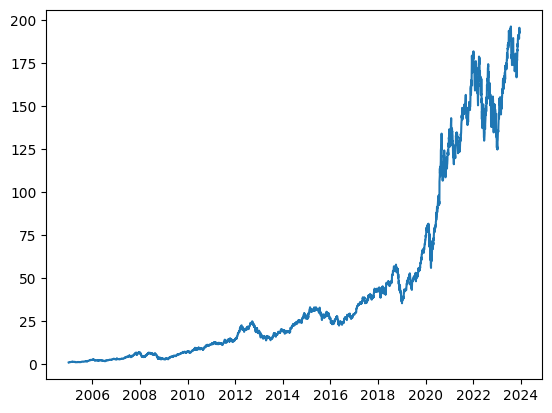

In [31]:
import matplotlib.pyplot as plt

plt.plot(df.index, df['Close'])

In [32]:
import numpy as np

def df_to_windowed_df(dataframe, n=3):
  target = df.loc[:,df.columns[-1]].to_numpy()
  dates = dataframe.index[n:].to_numpy()
  Y = target[n:]

  X = []
  i = 1
  while i != n + 1:
    X.append(target[n-i:-i])
    i += 1

  X.reverse()

  ret_df = pd.DataFrame()
  ret_df['Date'] = dates

  for j in range(0, n):
    ret_df[f'Target-{n-j}'] = X[j]

  ret_df['Target'] = Y

  return ret_df

windowed_df = df_to_windowed_df(df, n=3)
windowed_df

,Date,Target-3,Target-2,Target-1,Target
0,2005-01-06,1.130179,1.141786,1.151786,1.152679
1,2005-01-07,1.141786,1.151786,1.152679,1.236607
2,2005-01-10,1.151786,1.152679,1.236607,1.231429
3,2005-01-11,1.152679,1.236607,1.231429,1.152857
4,2005-01-12,1.236607,1.231429,1.152857,1.168929
...,...,...,...,...,...
4760,2023-12-05,189.949997,191.240005,189.429993,193.419998
4761,2023-12-06,191.240005,189.429993,193.419998,192.320007
4762,2023-12-07,189.429993,193.419998,192.320007,194.270004
4763,2023-12-08,193.419998,192.320007,194.270004,195.710007


In [33]:
def windowed_df_to_date_X_y(windowed_dataframe):
  df_as_np = windowed_dataframe.to_numpy()

  dates = df_as_np[:, 0]

  middle_matrix = df_as_np[:, 1:-1]
  X = middle_matrix.reshape((len(dates), middle_matrix.shape[1], 1))

  Y = df_as_np[:, -1]

  return dates, X.astype(np.float32), Y.astype(np.float32)

dates, X, y = windowed_df_to_date_X_y(windowed_df)
dates.shape, X.shape, y.shape

((4765,), (4765, 3, 1), (4765,))

476


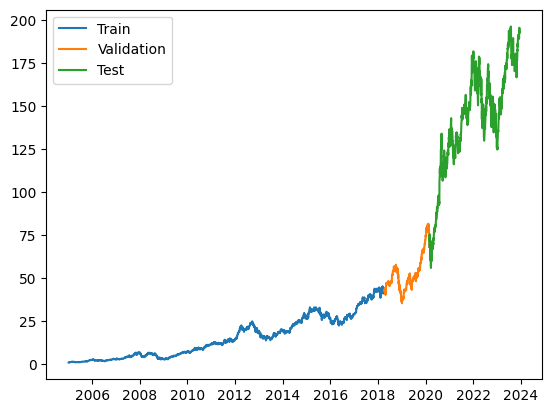

In [34]:
train_percentage = 0.7
val_percentage = 0.1
test_percentage = 0.2

assert train_percentage + val_percentage + test_percentage == 1

lim_train = int(len(dates) * train_percentage)
lim_val = int(len(dates) * val_percentage)

dates_train, X_train, y_train = dates[:lim_train], X[:lim_train], y[:lim_train]
dates_val, X_val, y_val = dates[lim_train: lim_train + lim_val], X[lim_train: lim_train + lim_val], y[lim_train: lim_train + lim_val]
dates_test, X_test, y_test = dates[ lim_train + lim_val:], X[ lim_train + lim_val:], y[ lim_train + lim_val:]

print(lim_val)

plt.plot(dates_train, y_train)
plt.plot(dates_val, y_val)
plt.plot(dates_test, y_test)

plt.legend(['Train', 'Validation', 'Test'])

In [35]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers

model = Sequential([layers.Input((3, 1)),
                    layers.LSTM(64),
                    layers.Dense(32, activation='relu'),
                    layers.Dense(32, activation='relu'),
                    layers.Dense(1)])

model.compile(loss='mse',
              optimizer=Adam(learning_rate=0.001),
              metrics=['mean_absolute_error'])

model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=7)

Epoch 1/7
105/105 [==============================] - 5s 14ms/step - loss: 123.9848 - mean_absolute_error: 6.7117 - val_loss: 273.6458 - val_mean_absolute_error: 13.1107
Epoch 2/7
105/105 [==============================] - 1s 5ms/step - loss: 0.2556 - mean_absolute_error: 0.3032 - val_loss: 158.1337 - val_mean_absolute_error: 8.5377
Epoch 3/7
105/105 [==============================] - 0s 5ms/step - loss: 0.1248 - mean_absolute_error: 0.2247 - val_loss: 141.1613 - val_mean_absolute_error: 7.8989
Epoch 4/7
105/105 [==============================] - 1s 5ms/step - loss: 0.1193 - mean_absolute_error: 0.2237 - val_loss: 130.9295 - val_mean_absolute_error: 7.3669
Epoch 5/7
105/105 [==============================] - 1s 5ms/step - loss: 0.1071 - mean_absolute_error: 0.2105 - val_loss: 124.3054 - val_mean_absolute_error: 7.0149
Epoch 6/7
105/105 [==============================] - 1s 5ms/step - loss: 0.1450 - mean_absolute_error: 0.2481 - val_loss: 123.7812 - val_mean_absolute_error: 7.0064
Epoch 

105/105 [==============================] - 1s 2ms/step


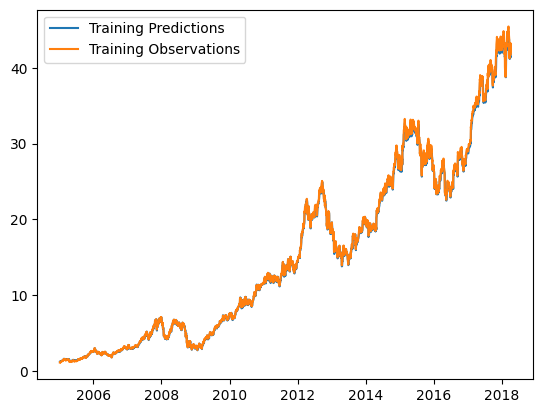

In [36]:
train_predictions = model.predict(X_train).flatten()

plt.plot(dates_train, train_predictions)
plt.plot(dates_train, y_train)
plt.legend(['Training Predictions', 'Training Observations'])

15/15 [==============================] - 0s 2ms/step


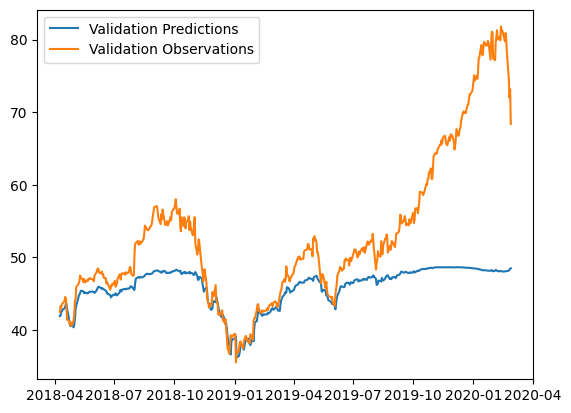

In [37]:
val_predictions = model.predict(X_val).flatten()

plt.plot(dates_val, val_predictions)
plt.plot(dates_val, y_val)
plt.legend(['Validation Predictions', 'Validation Observations'])

30/30 [==============================] - 0s 2ms/step


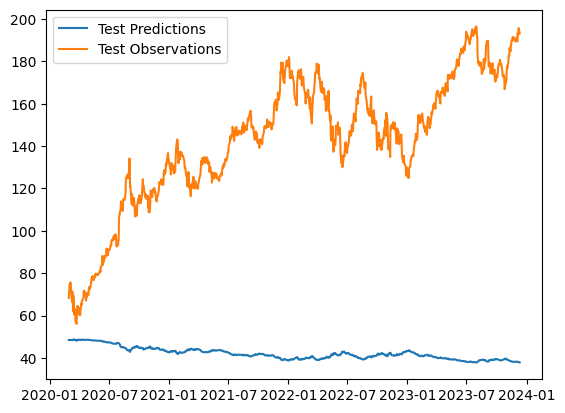

In [38]:
test_predictions = model.predict(X_test).flatten()

plt.plot(dates_test, test_predictions)
plt.plot(dates_test, y_test)
plt.legend(['Test Predictions', 'Test Observations'])

In [39]:
score = model.evaluate(X_test, y_test)

30/30 [==============================] - 0s 2ms/step - loss: 11251.4980 - mean_absolute_error: 100.5291


In [40]:
import datetime

actually_window = windowed_df[windowed_df["Date"] > datetime.datetime(year=2020, month=1, day=1)]
actually_window.head()

,Date,Target-3,Target-2,Target-1,Target
3772,2020-01-02,72.449997,72.879997,73.412498,75.087502
3773,2020-01-03,72.879997,73.412498,75.087502,74.357498
3774,2020-01-06,73.412498,75.087502,74.357498,74.949997
3775,2020-01-07,75.087502,74.357498,74.949997,74.597504
3776,2020-01-08,74.357498,74.949997,74.597504,75.797501


In [41]:
dates, X, y = windowed_df_to_date_X_y(actually_window)
dates.shape, X.shape, y.shape

((993,), (993, 3, 1), (993,))

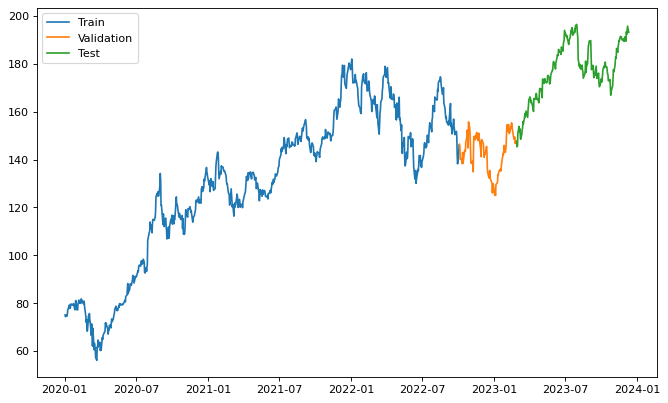

In [42]:
train_percentage = 0.7
val_percentage = 0.1
test_percentage = 0.2

assert train_percentage + val_percentage + test_percentage == 1

lim_train = int(len(dates) * train_percentage)
lim_val = int(len(dates) * val_percentage)

dates_train, X_train, y_train = dates[:lim_train], X[:lim_train], y[:lim_train]
dates_val, X_val, y_val = dates[lim_train: lim_train + lim_val], X[lim_train: lim_train + lim_val], y[lim_train: lim_train + lim_val]
dates_test, X_test, y_test = dates[ lim_train + lim_val:], X[ lim_train + lim_val:], y[ lim_train + lim_val:]

plt.figure(figsize=(10, 6), dpi=80)

plt.plot(dates_train, y_train)
plt.plot(dates_val, y_val)
plt.plot(dates_test, y_test)

plt.legend(['Train', 'Validation', 'Test'])

In [43]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers

model = Sequential([layers.Input((3, 1)),
                    layers.LSTM(128),
                    layers.Dense(64, activation='relu'),
                    layers.Dense(64, activation='relu'),
                    layers.Dense(1)])

model.compile(loss='mse',
              optimizer=Adam(learning_rate=0.001),
              metrics=['mean_absolute_error'])

model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=10)

Epoch 1/10
22/22 [==============================] - 3s 47ms/step - loss: 17038.1094 - mean_absolute_error: 126.6504 - val_loss: 18771.6895 - val_mean_absolute_error: 136.7872
Epoch 2/10
22/22 [==============================] - 0s 13ms/step - loss: 14162.6465 - mean_absolute_error: 114.2887 - val_loss: 12657.7412 - val_mean_absolute_error: 112.2119
Epoch 3/10
22/22 [==============================] - 0s 15ms/step - loss: 5729.9902 - mean_absolute_error: 66.3013 - val_loss: 1169.1902 - val_mean_absolute_error: 33.2180
Epoch 4/10
22/22 [==============================] - 0s 14ms/step - loss: 1097.9250 - mean_absolute_error: 26.6447 - val_loss: 93.0679 - val_mean_absolute_error: 8.3911
Epoch 5/10
22/22 [==============================] - 0s 13ms/step - loss: 919.8173 - mean_absolute_error: 24.6228 - val_loss: 301.9563 - val_mean_absolute_error: 16.0037
Epoch 6/10
22/22 [==============================] - 0s 14ms/step - loss: 326.0211 - mean_absolute_error: 13.3720 - val_loss: 14.0348 - val_mea

22/22 [==============================] - 0s 3ms/step


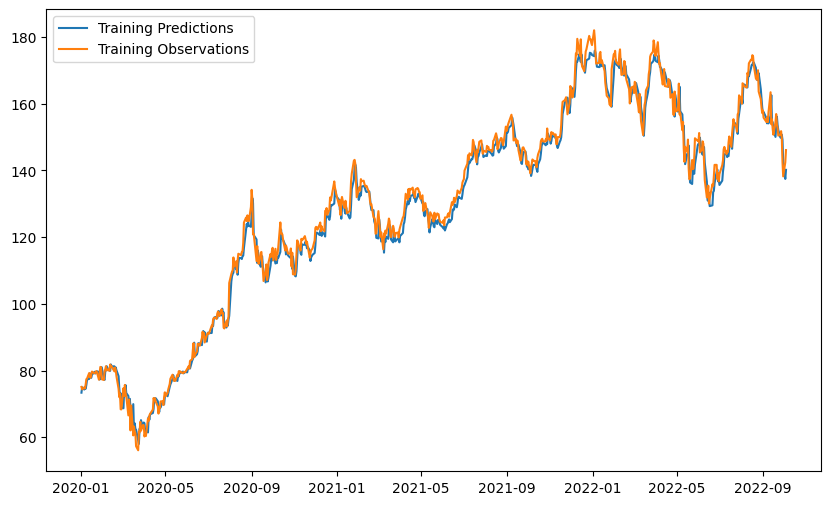

In [44]:
train_predictions = model.predict(X_train).flatten()

plt.figure(figsize=(10, 6))
plt.plot(dates_train, train_predictions)
plt.plot(dates_train, y_train)
plt.legend(['Training Predictions', 'Training Observations'])

4/4 [==============================] - 0s 4ms/step


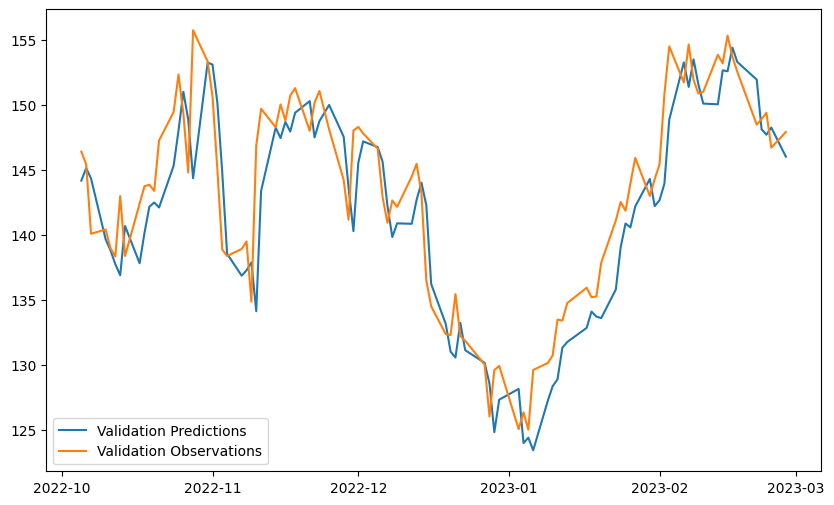

In [45]:
val_predictions = model.predict(X_val).flatten()

plt.figure(figsize=(10, 6))
plt.plot(dates_val, val_predictions)
plt.plot(dates_val, y_val)
plt.legend(['Validation Predictions', 'Validation Observations'])

7/7 [==============================] - 0s 4ms/step


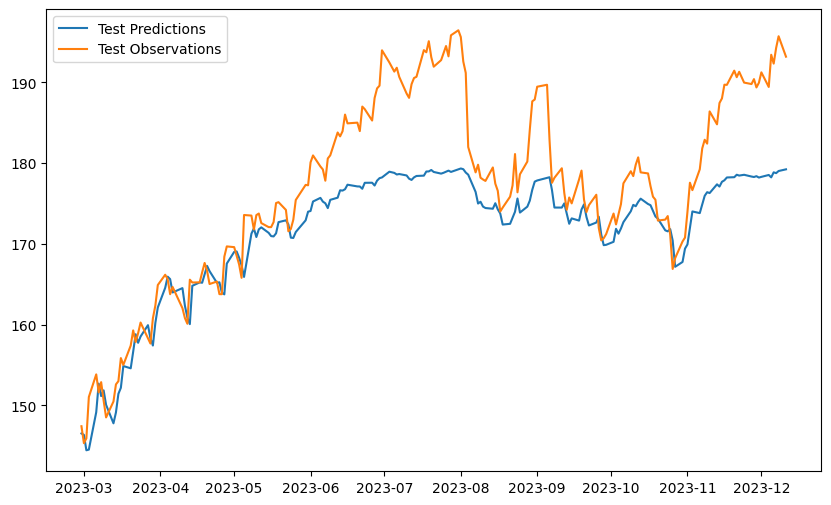

In [46]:
test_predictions = model.predict(X_test).flatten()

plt.figure(figsize=(10, 6))
plt.plot(dates_test, test_predictions)
plt.plot(dates_test, y_test)
plt.legend(['Test Predictions', 'Test Observations'])

In [47]:
score = model.evaluate(X_test, y_test)
score

7/7 [==============================] - 0s 4ms/step - loss: 54.7406 - mean_absolute_error: 5.5931


[54.740596771240234, 5.593084335327148]

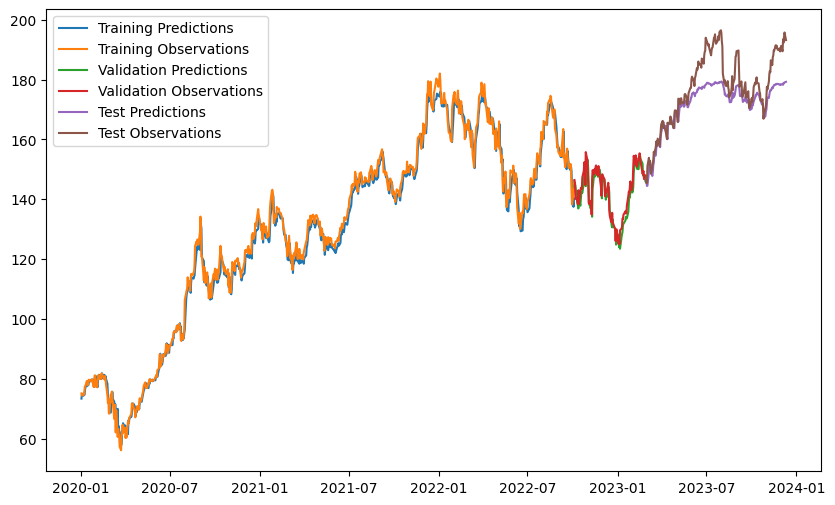

In [49]:
plt.figure(figsize=(10, 6))
plt.plot(dates_train, train_predictions)
plt.plot(dates_train, y_train)
plt.plot(dates_val, val_predictions)
plt.plot(dates_val, y_val)
plt.plot(dates_test, test_predictions)
plt.plot(dates_test, y_test)

plt.legend(['Training Predictions', 'Training Observations', 'Validation Predictions', 'Validation Observations', 'Test Predictions', 'Test Observations'])